# A/B Test Click-Through Rate Analysis

### Is the difference between this two click rates real or it have happened just by chance? 

$$
\begin{cases}
H_0: p_{con} = p_{exp} \\
H_1: p_{con} \ne p_{exp}
\end{cases}
$$

---

## Loading and Cleaning our Data for AB Test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
# Load the data
df = pd.read_csv('ab_test_data.csv')
df

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00
...,...,...,...,...
19995,19996,1,con,NaN
19996,19997,1,con,NaN
19997,19998,1,con,NaN
19998,19999,0,con,NaN


In [3]:
# Chaek the shape (row, column)
df.shape

(20000, 4)

In [4]:
# Check exactly where the missing values are and how much of them
df.isna().sum()

user_id          0
click            0
group            0
timestamp    10000
dtype: int64

In [5]:
# Details from numerical column
df.describe()

,user_id,click
count,20000.000000,20000.000000
mean,10000.500000,0.405250
std,5773.647028,0.490953
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,0.000000
75%,15000.250000,1.000000
max,20000.000000,1.000000


In [6]:
# Check the columns
df.columns

Index(['user_id', 'click', 'group', 'timestamp'], dtype='object')

In [7]:
# Clean the dataframe, dropping timestamp column
df.drop('timestamp', axis=1, inplace=True)
df

,user_id,click,group
0,1,1,exp
1,2,0,exp
2,3,1,exp
3,4,0,exp
4,5,1,exp
...,...,...,...
19995,19996,1,con
19996,19997,1,con
19997,19998,1,con
19998,19999,0,con


---

## Clicks and Probability

In [8]:
# Total number of users per group
N_con = df.group.value_counts().iloc[0].item()
N_exp = df.group.value_counts().iloc[1].item()

# Verify the number of users are the same
assert N_con == N_exp

# Total number of click per group
X_con = df.groupby('group').sum('click').click.iloc[0].item()
X_exp = df.groupby('group').sum('click').click.iloc[1].item()

# Print
print(df.groupby('group').sum('click').click)
print(f'\nNumber of users in Control:       {N_con}')
print(f'Number of ursers in Experimental: {N_exp}')
print(f'Number of Clicks in Control:       {X_con}')
print(f'Number of Clicks in Experimental:  {X_exp}')


group
con    1989
exp    6116
Name: click, dtype: int64

Number of users in Control:       10000
Number of ursers in Experimental: 10000
Number of Clicks in Control:       1989
Number of Clicks in Experimental:  6116


In [9]:
# Estimate of clicks probability per group
p_con =  X_con/N_con
p_exp = X_exp/N_exp

# Estimate of pooled clicked probability
p_pooled = (X_con + X_exp) / (N_con + N_exp)

# Print
print(f'Click Probability in Control:      {p_con} → {p_con*100:.1f}%')
print(f'Click Probability in Experimental: {p_exp} → {p_exp*100:.1f}%')
print(f'Pooled Clicked Probability:        {p_pooled}')


Click Probability in Control:      0.1989 → 19.9%
Click Probability in Experimental: 0.6116 → 61.2%
Pooled Clicked Probability:        0.40525


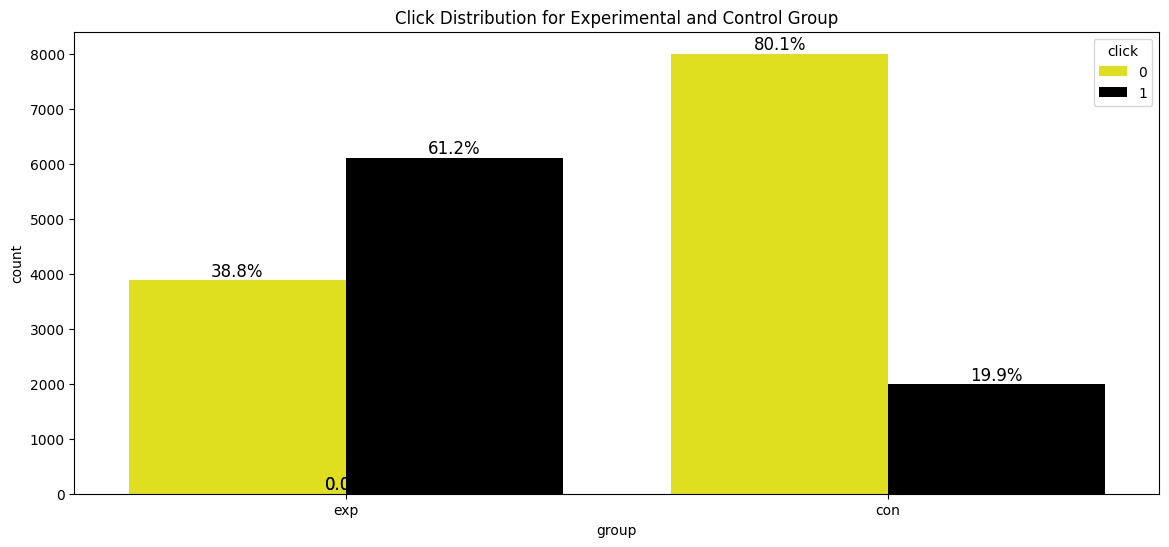

In [10]:
# Plot
plt.figure(figsize=(14,6))
ax = sns.countplot(data = df, 
              x='group', 
              hue='click',
              palette = {0: 'yellow', 1:'black'}
              )

plt.title('Click Distribution for Experimental and Control Group')

# Add text on top of each bar
for p in ax.patches:               # ax.patches = bars
    # Get the height of each bar
    height = p.get_height()
    # Add text at the top of each bar
    ax.text(p.get_x() + p.get_width() / 2, height + 170, f'{(height/N_con)*100:.1f}%', # get(x) x of left edge, N_con = N_exp = 10000
            ha='center', va='center', fontsize=12, color='black')

# Save plot
plt.savefig('plots/click_distribution_control_and_experimental_group.png')   


## Parameters of the Model for Power Analysis 

- **β**: Probability of Type II Error
- **(1 - β)**: Power of the test
- **α**: Probability of Type I Error, Significance Level
- **δ**: Minimum Detectable Effect

In [11]:
alpha = 0.05 # 5%
print("Alpha: significance level is:", alpha )

delta = 0.1 # 10%
print("Delta: minimum detectable effect (MDE) is:", delta )

Alpha: significance level is: 0.05
Delta: minimum detectable effect (MDE) is: 0.1


## Pooled Variance 

In [12]:
pooled_variance = p_pooled * (1-p_pooled) * (1/N_con + 1/N_exp)
print("p^_pooled, estimates clicked probability: ", p_pooled)
print("pooled_variance is:                       ",pooled_variance)

p^_pooled, estimates clicked probability:  0.40525
pooled_variance is:                        4.82044875e-05


## Standard Error and Test Statistics (z-score)

In [13]:
# Computing the standard error of the test
SE = np.sqrt(pooled_variance)
print("Standard Error is:                                  ", SE)

# Computing the test statistics (z-score) of Z-test: how far apart these two groups are in standard error units, under the assumption that the null is true
Test_stat = (p_exp - p_con)/SE
print("Test Statistics (z_score) for 2-sample Z-test is:   ", Test_stat)

# Critical value of the Z-test
Z_crit = norm.ppf(1-alpha/2)
print("Z-critical value from Standard Normal distribution: ", Z_crit)

print(f'\nThe critical value of {round(Z_crit, 2)}, sets the threshold for deciding wheter a result is statistically significant.')
print(f'\nIf the z_score (test score) goes beyond that line, the result is unlikely to have happened by chance: the null hypothesis is rejected.')
print('\nCritical value defines the minimum amount of evedince needed to say: this result is unlikely to be random.')
print('\nCritical value sets the cutoff and z-score must be more extreme to show statistical evidence that a real difference exists.')

Standard Error is:                                   0.006942945160376826
Test Statistics (z_score) for 2-sample Z-test is:    59.44163326469381
Z-critical value from Standard Normal distribution:  1.959963984540054

The critical value of 1.96, sets the threshold for deciding wheter a result is statistically significant.

If the z_score (test score) goes beyond that line, the result is unlikely to have happened by chance: the null hypothesis is rejected.

Critical value defines the minimum amount of evedince needed to say: this result is unlikely to be random.

Critical value sets the cutoff and z-score must be more extreme to show statistical evidence that a real difference exists.


# p_value of the Z-test

### <span style='color:red'> **p-value**: If there were no real difference, what's the probability I'd see a difference this big or bigger just by chance? </span>

- A low **p-value** (p ≤ 0.05 at 5% significance level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis.
- A high **p-value** (p > 0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis.

In [14]:
# Calculate two-tailed p-value
p_value = 2 * (1 - norm.cdf(abs(Test_stat)))


print(f"z-score: {Test_stat:.2f}")
print(f"p-value: {p_value:.20e}")

z-score: 59.44
p-value: 0.00000000000000000000e+00


## Statistical Significance

In [15]:
# function checking the statistical significance
def is_statistical_significance(p_value, alpha):
    """
    We assess whether there is statistical significance based on the p-value and alpha.

    Arguments:
    - p_value (float): The p-value resulting from a statistical test.
    - alpha (float, optional): The significance level threshold used to determine statistical significance. Defaults to 0.05.

    Returns:
    - Prints the assessment of statistical significance.
    """

    # Print the rounded p-value to 3 decimal places
    print(f"P-value of the 2-sample Z-test: {(p_value)}")

    # Determine statistical significance
    if p_value <= alpha:
        print("\nThere is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone.\nThis suggests that the changes in the experimental group have a real effect compared to the control group.")
    else:
        print("\nThere is no statistical significance, suggesting that the observed differences between the groups could have occurred by chance.\nThis implies that the changes in the experimental group do not have a substantial effect compared to the control group.")



is_statistical_significance(p_value, alpha)

P-value of the 2-sample Z-test: 0.0

There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone.
This suggests that the changes in the experimental group have a real effect compared to the control group.


In [16]:
print(f'If the null hypothesis were true (i.e. theres is no real difference between the control and the experimental click rates),\nthen the chance of observing a difference as large as  {(p_exp-p_con):.4f}, or larger, purely due to random chance is essentially {p_value} ')

If the null hypothesis were true (i.e. theres is no real difference between the control and the experimental click rates),
then the chance of observing a difference as large as  0.4127, or larger, purely due to random chance is essentially 0.0 


## Confidence Interval (**CI**)

In [17]:
difference_prob = p_exp - p_con

CI_95 = [(difference_prob - Z_crit * SE), (difference_prob + Z_crit * SE)]
print(f'We are 95% confident that the true increase in click is between: {CI_95[0]:.3f} and {CI_95[1]:.3f} →  {CI_95[0]*100:.3f}% and {CI_95[1]*100:.3f}%')

We are 95% confident that the true increase in click is between: 0.399 and 0.426 →  39.909% and 42.631%


## Practical Significance

In [18]:
def is_practically_significant(delta, CI_95):
    """
    Assess whether the difference between Control and Experimental group is practically significant
    using the Minimum Detectable Effect (MDE).

    Parameters:
    - delta (float): The Minimum Detectable Effect (MDE) threshold.
    - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% Confidence Interval.

    Returns:
    - bool: True if practically significant, False otherwise.
    """
    lower_bound_CI = CI_95[0]

    if lower_bound_CI >= delta:
        print(f"✅ We have practical significance!\nThe lower bound of the 95% CI ({lower_bound_CI:.4f}) exceeds the MDE ({delta}).")
        return True
    else:
        print(f"❌ Not practically significant.\nThe lower bound of the 95% CI ({lower_bound_CI:.4f}) is less than the MDE ({delta}).")
        return False

In [19]:
print(f"Lower bound of 95% confidence interval is: { CI_95[0]:.4f}")
significance = is_practically_significant(delta, CI_95)

Lower bound of 95% confidence interval is: 0.3991
✅ We have practical significance!
The lower bound of the 95% CI (0.3991) exceeds the MDE (0.1).


# Plots

---

## - Click Rates with 95% Confidence

### This bar plot displays the observed click-through rates (CTR) for the Control and Experiment groups. Each bar shows the point estimate of the CTR, with vertical error bars representing the 95% confidence interval, illustrating the uncertainty around the estimated rates.

In [20]:
# Control Group

# Standard Error Control
SE_con = np.sqrt(p_con * (1 - p_con) * (1 / N_con))

# Marging Error Control
ME_con = Z_crit * SE_con

# Confidence Interval Control
CI_con = [(p_con - ME_con), (p_con + ME_con)] 

print(f'The CI 95% for Control Group is: {CI_con[0]:.4f}, {CI_con[1]:.4f}')

The CI 95% for Control Group is: 0.1911, 0.2067


In [21]:
# Experimental Group

# Standard Error Experimental 
SE_exp = np.sqrt(p_exp * (1 - p_exp) * (1 / N_exp))

# Margin Error Experimental 
ME_exp = Z_crit * SE_exp

# Confidence Interval Experimental
CI_exp = [(p_exp - ME_exp), (p_exp + ME_exp)]

print(f'The CI 95% for Experimental Group is: {CI_exp[0]:.4f}, {CI_exp[1]:.4f}')

The CI 95% for Experimental Group is: 0.6020, 0.6212


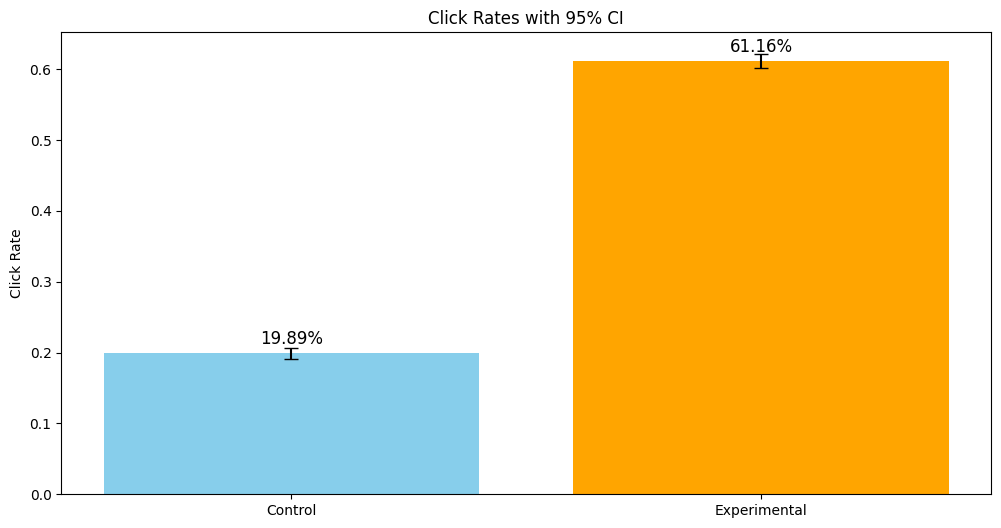

In [22]:
# Plot

plt.figure(figsize=(12,6))
bar_colors = ['skyblue', 'orange']
bars = plt.bar(['Control', 'Experimental'], [p_con, p_exp], yerr = [ME_con, ME_exp], color=bar_colors, capsize=5)

plt.ylabel('Click Rate')
plt.title('Click Rates with 95% CI')

ax = plt.gca() # Get current axes

# Add text on top of each bar
for p in ax.patches:               # ax.patches = bars
    # Get the height of each bar
    height = p.get_height()
    # Add text at the top of each bar
    ax.text(p.get_x() + p.get_width() / 2, height + 0.02, f'{height:.2%}', # get(x) x of left edge, N_con = N_exp = 10000
            ha='center', va='center', fontsize=12, color='black')

plt.savefig('plots/click_rates_with_95_perc_ci.png')



---

## - Difference in Click Rates with 95% Confidence Interval

### This plot shows the difference in CTR between the Experiment and Control groups, along with the 95% confidence interval for this difference. The horizontal line at zero represents the null hypothesis of no difference. If zero is not within the confidence interval, the difference is statistically significant at the 5% level.

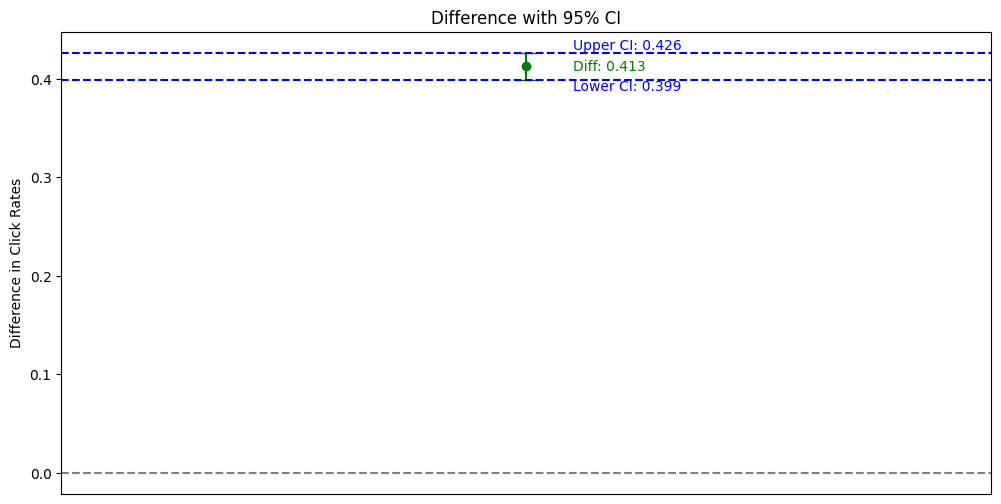

In [23]:
plt.figure(figsize=(12,6))
plt.errorbar(0, difference_prob, yerr=Z_crit*SE, fmt='o', color='green', capsize=8)
plt.axhline(0, color='grey', linestyle='--')
plt.axhline(CI_95[1], linestyle='--', color='blue')
plt.axhline(CI_95[0], linestyle='--', color='blue')

# Annotations
plt.text(0.1, CI_95[1], f"Upper CI: {CI_95[1]:.3f}", color='blue', va='bottom')
plt.text(0.1, CI_95[0], f"Lower CI: {CI_95[0]:.3f}", color='blue', va='top')
plt.text(0.1, difference_prob, f"Diff: {difference_prob:.3f}", color='green', va='center')

plt.xlim(-1, 1)
plt.xticks([]) # Clean the axis, it's irrelevant
plt.ylabel('Difference in Click Rates')
plt.title('Difference with 95% CI')

plt.savefig('plots/difference_in_click_rates_with_95_perc_ci.png')

---

## - Z-test: Null Distribution and Test Statistic

### This plot visualizes the standard normal distribution under the null hypothesis (no difference). The red shaded areas indicate the rejection regions for a two-tailed test at the 5% significance level. The observed z-score from the data is marked, with the corresponding p-value displayed, helping to assess statistical significance.

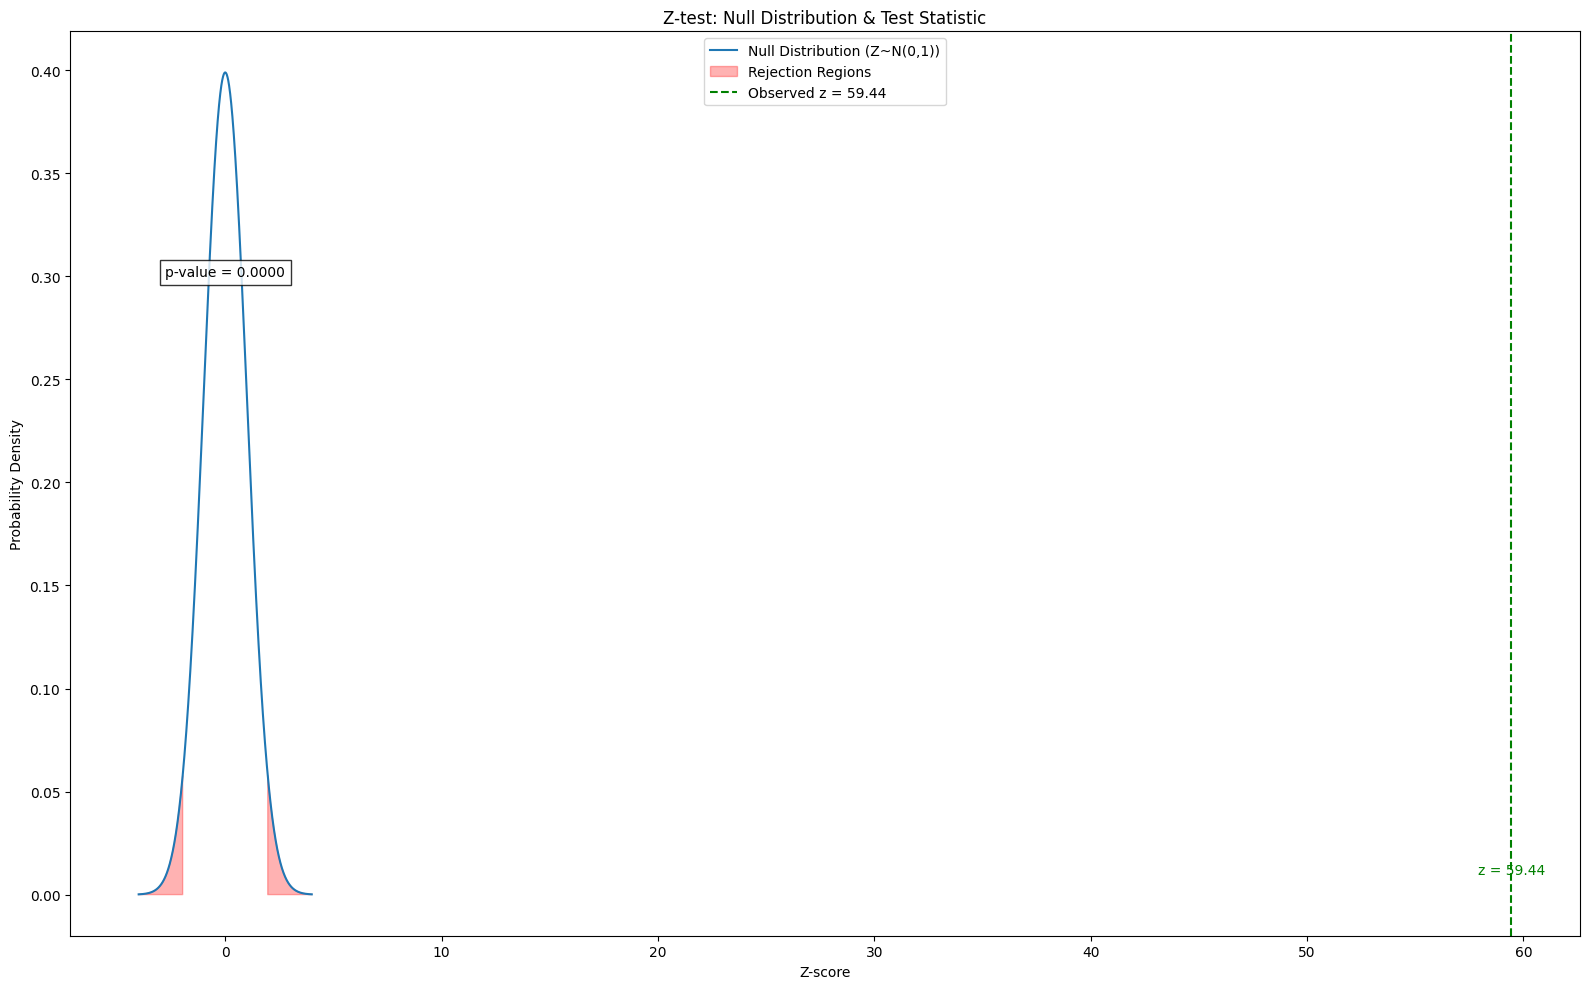

In [25]:
plt.figure(figsize=(16,10))

x = np.linspace(-4, 4, 1000) 
y = norm.pdf(x)

# plot Z-score on Normal Distribution 
plt.plot(x, y, label='Null Distribution (Z~N(0,1))')
plt.fill_between(x, 0, norm.pdf(x), where=(np.abs(x) > Z_crit), color='red', alpha=0.3, label='Rejection Regions')

# Mark the observed z-score
plt.axvline(Test_stat, color='green', linestyle='--', label=f'Observed z = {Test_stat:.2f}')
plt.text(Test_stat, norm.pdf(Test_stat)+0.01, f'z = {Test_stat:.2f}', color='green', ha='center')
plt.text(0, 0.3, f'p-value = {p_value:.4f}', ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.title('Z-test: Null Distribution & Test Statistic')
plt.xlabel('Z-score')
plt.ylabel('Probability Density')
plt.legend(loc='upper center')

plt.tight_layout()
plt.savefig('plots/z_test_null_distribution_and_test_statistic.png')

plt.show()